In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io

In [2]:
# Seeds
torch.manual_seed(123456)
np.random.seed(123456)

In [3]:
# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 7):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                # Neural network
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
        gamma = 1.4                                                    # Heat Capacity Ratio

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]                    # Partial derivatives rho_t, rho_x


        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            # Partial derivatives u_t, u_x


        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            # Partial derivatives p_t, p_x

        # Loss function for the Euler Equations
        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()

        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics

In [4]:
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

In [5]:
# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

In [6]:
# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition

    # rho, p - initial condition
    for i in range(N):
        if (x[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

In [7]:
# Initialization
device = torch.device('cuda:0')                                          # Run on CPU
lr = 0.0005                                                           # Learning rate
num_x = 1000                                                          # Number of points in t
num_t = 1000                                                          # Number of points in x
num_i_train = 1000                                                    # Random sampled points from IC
epochs = 76140                                                        # Number of iterations
num_f_train = 11000                                                   # Random sampled points in interior
x = np.linspace(-1.5, 3.125, num_x)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, num_t)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid

id_ic = np.random.choice(num_x, num_i_train, replace=False)           # Random sample numbering for IC
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)      # Random sample numbering for interior

x_ic = x_grid[id_ic, 0][:, None]                                      # Random x - initial condition
t_ic = t_grid[id_ic, 0][:, None]                                      # random t - initial condition
x_ic_train = np.hstack((t_ic, x_ic))                                  # Random (x,t) - vectorized
rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)                       # Initial condition evaluated at random sample

x_int = X[:, 0][id_f, None]                                           # Random x - interior
t_int = T[:, 0][id_f, None]                                           # Random t - interior
x_int_train = np.hstack((t_int, x_int))                               # Random (x,t) - vectorized
x_test = np.hstack((T, X))                                            # Vectorized whole domain

# Generate tensors
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

# Initialize neural network
model = DNN().to(device)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train PINNs
def train(epoch):
        model.train()
        def closure():
            optimizer.zero_grad()                                                     # Optimizer
            loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
            loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   # Loss function of IC
            loss = 0.1*loss_pde + 10*loss_ic                                          # Total loss function G(theta)

            # Print iteration, loss of PDE and ICs
            if epoch % 1000==0:
                print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
            loss.backward()
            return loss

        # Optimize loss function
        loss = optimizer.step(closure)
        loss_value = loss.item() if not isinstance(loss, float) else loss
        # Print total loss
        if epoch % 1000==0:
            print(f'epoch {epoch}: Total loss: {loss_value:.6f}')

    # Print CPU
print('Start training...')
tic = time.time()
for epoch in range(1, epochs+1):
        train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

Start training...
epoch 1000 loss_pde:0.25332713, loss_ic:0.00499574
epoch 1000: Total loss: 0.075290
epoch 2000 loss_pde:0.04554236, loss_ic:0.00114518
epoch 2000: Total loss: 0.016006
epoch 3000 loss_pde:0.02831334, loss_ic:0.00063057
epoch 3000: Total loss: 0.009137
epoch 4000 loss_pde:0.02087883, loss_ic:0.00026693
epoch 4000: Total loss: 0.004757
epoch 5000 loss_pde:0.01512440, loss_ic:0.00006220
epoch 5000: Total loss: 0.002134
epoch 6000 loss_pde:0.01210846, loss_ic:0.00002378
epoch 6000: Total loss: 0.001449
epoch 7000 loss_pde:0.01066530, loss_ic:0.00001443
epoch 7000: Total loss: 0.001211
epoch 8000 loss_pde:0.00947595, loss_ic:0.00001131
epoch 8000: Total loss: 0.001061
epoch 9000 loss_pde:0.00850861, loss_ic:0.00001023
epoch 9000: Total loss: 0.000953
epoch 10000 loss_pde:0.00749179, loss_ic:0.00000836
epoch 10000: Total loss: 0.000833
epoch 11000 loss_pde:0.00669763, loss_ic:0.00000799
epoch 11000: Total loss: 0.000750
epoch 12000 loss_pde:0.00604018, loss_ic:0.00000821
ep

In [21]:
# Evaluate on the whole computational domain
num_x = 5000
num_t = 1000
x = np.linspace(0, 1, num_x)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, num_t)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid

x_test = np.hstack((T, X))
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))
scipy.io.savemat('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
                                                              'u': u_pred[:,2],
                                                              'p': u_pred[:,1]})

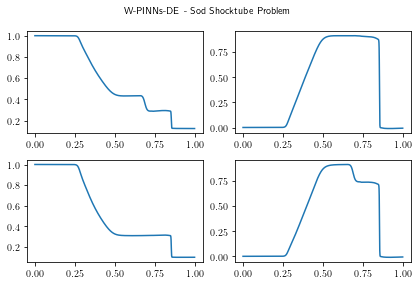

In [22]:
data = scipy.io.loadmat('Sod_Shock_Tube.mat')                                 # Import Solution data

xc   = data['x'].flatten()[:,None]                                            
rho = data['rho'].flatten()[:,None]
rho = np.reshape(rho, (len(x),len(t)))
rho = rho[:,-1]
u   = data['u'].flatten()[:,None]
u = np.reshape(u, (len(x),len(t)))
u = u[:,-1]
p   = data['p'].flatten()[:,None]
p = np.reshape(p, (len(x),len(t)))
p = p[:,-1]
M = u/np.sqrt(1.4*p/rho)


    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.plot(xc, rho)
ax2.plot(xc, u)
ax3.plot(xc, p)
ax4.plot(xc, M)
        


#fig.legend(['Exact', 'FV-PINNs'], ncol = 2, loc='lower center', fontsize= 4)
csfont = {'fontname':'serif'}
plt.suptitle(r'W-PINNs-DE - Sod Shocktube Problem', fontsize= 10, **csfont)
plt.tight_layout()
plt.show()